# Predicting Credit Default

#### Preface 

  In their seminal paper, Yeh and Lien (2009) demonstrated the practical applicability of feedforward     neural networks in predicting credit default. They compared the feedforward neural network to 5 other   classification algorithms (k-nearest neighbors, classification trees, logistic regression,             discriminant analysis, and naive Bayes) and found the former to be the most accurate by a               considerable margin. This project extends their analysis by evaluating the accuracy of the             feedforward neural network against Adaboost and the SVC (Support Vector Classifier), two of the most   robust and commonly used algorithms for classification. Additionally, because expediency is often       crucial in business decisions, the 3 will also be evaluated on execution time. 

### Data Acquisition and Preparation

#### Source
Dataset was obtained from the UCI Machine Learning Repository. Link: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients# 
<br/><br/>
#### Comments 
Yeh and Lien describe the features as such:
<br/><br/>
_"This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
X2: Gender (1 = male; 2 = female). 
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
X4: Marital status (1 = married; 2 = single; 3 = others). 
X5: Age (year). 
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. "_ 

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#data = pd.read_csv('data/UCI_Credit_Card.csv', index_col='ID')
data = pd.read_csv('data/preliminary.csv', index_col='ID')
data.rename(columns = lambda x: x.lower(), inplace=True)

# Creating binary encodings for categorical variables. 0 values are "female," 
# "other education," "single"

data['grad_school'] = (data['education'] == 1).astype('int')
data['university'] = (data['education'] == 2).astype('int')
data['high_school'] = (data['education'] == 3).astype('int')
data.drop('education', axis=1, inplace=True)
data['male'] = (data['sex']==1).astype('int')
data.drop('sex', axis=1, inplace=True)
data['married'] = (data['marriage'] == 1).astype('int')
data.drop('marriage', axis=1, inplace=True)

# Some of the pay months have negative values, which correspond to paying on
# time. These values were changed to 0 to group all as "non-default."

pay_dates = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
for p in pay_dates:
    data.loc[data[p]<=0, p] = 0

data.rename(columns={'default.payment.next.month':'default'}, inplace=True) 
print(data.shape)
k = data.shape[1]

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler 

features = data.drop('default', axis=1)
labels = data['default']
robust = RobustScaler()
features = robust.fit_transform(features)
train_X, test_X, train_Y, test_Y = train_test_split(features, labels, test_size=0.1, 
                                                    random_state=123, stratify=labels)

(239, 26)


### Model Construction 

In [36]:
# Neural Network 
import keras
import feedforward_ks as fks # A feedforward network model builder from a previous project

# The networks tested will range from 1 (simple, quicker) to 3 (complex, more accurate)
# Defaults of the model builder: ReLu activation function, Adam optimizer, MSE loss, final
# output is a sigmoid function. 
net_model1 = fks.FFNetwork([k-1, 10, 1])
net_model2 = fks.FFNetwork([k-1, 20, 10, 1])
net_model3 = fks.FFNetwork([k-1, 40, 20, 10, 1])

# Support Vector Classifier
from sklearn.svm import SVC

# The support vector classifiers will each have a different kernel function
# Default parameters: sklearn's default parameters for C, gamma, and degree will be used
# but are left in the code to be changed if desired
svc_model_lin = SVC(C = 1.0, kernel='linear')
svc_model_rbf = SVC(C = 1.0, gamma = 'auto')
svc_model_pol = SVC(C = 1.0, kernel='poly', degree = 3, gamma = 'auto') 

# Adaboost 
from sklearn.ensemble import AdaBoostClassifier

# The default base estimator for adaboost is a decision tree of depth 1 
# The classifiers are ranked based on the number of estimators they use before terminating
# 1 is the quickest, least complex, while 3 is the most complex and slowest to compute
ada_model1 = AdaBoostClassifier(n_estimators = 50)
ada_model2 = AdaBoostClassifier(n_estimators = 100)
ada_model3 = AdaBoostClassifier(n_estimators = 200)

### Evaluative Metrics

In [37]:
import time
from sklearn.metrics import accuracy_score

metrics = pd.DataFrame(index=['accuracy', 'time'],
                      columns=['NET1', 'NET2', 'NET3', 'SVML', 'SVMR', 'SVMP', 
                               'ADA1', 'ADA2', 'ADA3'])

### Running the Models

In [38]:
# Hyperparameters 
epochs = 30
batch_size = 32
learn_rate = 0.01

start = time.time()
net_model1.run_model(train_X, train_Y, epochs, batch_size, learn_rate)
end = time.time()
metrics.loc['time', 'NET1'] = end - start 
accuracy = net_model1.evaluate(test_X, test_Y)[1]
metrics.loc['accuracy', 'NET1'] = accuracy

start = time.time()
net_model2.run_model(train_X, train_Y, epochs, batch_size, learn_rate)
end = time.time()
metrics.loc['time', 'NET2'] = end - start 
accuracy = net_model2.evaluate(test_X, test_Y)[1]
metrics.loc['accuracy', 'NET2'] = accuracy

start = time.time()
net_model3.run_model(train_X, train_Y, epochs, batch_size, learn_rate)
end = time.time()
metrics.loc['time', 'NET3'] = end - start 
accuracy = net_model3.evaluate(test_X, test_Y)[1]
metrics.loc['accuracy', 'NET3'] = accuracy

start = time.time()
svc_model_lin.fit(train_X, train_Y)
end = time.time()
metrics.loc['time', 'SVML'] = end - start 
prediction = svc_model_lin.predict(test_X)
metrics.loc['accuracy', 'SVML'] = accuracy_score(y_pred=prediction, y_true=test_Y)

start = time.time()
svc_model_rbf.fit(train_X, train_Y)
end = time.time()
metrics.loc['time', 'SVMR'] = end - start 
prediction = svc_model_rbf.predict(test_X)
metrics.loc['accuracy', 'SVMR'] = accuracy_score(y_pred=prediction, y_true=test_Y)

start = time.time()
svc_model_pol.fit(train_X, train_Y)
end = time.time()
metrics.loc['time', 'SVMP'] = end - start 
prediction = svc_model_pol.predict(test_X)
metrics.loc['accuracy', 'SVMP'] = accuracy_score(y_pred=prediction, y_true=test_Y)

start = time.time()
ada_model1.fit(train_X, train_Y)
end = time.time()
metrics.loc['time', 'ADA1'] = end - start 
prediction = ada_model1.predict(test_X)
metrics.loc['accuracy', 'ADA1'] = accuracy_score(y_pred=prediction, y_true=test_Y)

start = time.time()
ada_model2.fit(train_X, train_Y)
end = time.time()
metrics.loc['time', 'ADA2'] = end - start 
prediction = ada_model2.predict(test_X)
metrics.loc['accuracy', 'ADA2'] = accuracy_score(y_pred=prediction, y_true=test_Y)

start = time.time()
ada_model3.fit(train_X, train_Y)
end = time.time()
metrics.loc['time', 'ADA3'] = end - start 
prediction = ada_model3.predict(test_X)
metrics.loc['accuracy', 'ADA3'] = accuracy_score(y_pred=prediction, y_true=test_Y)

### Comparing Results

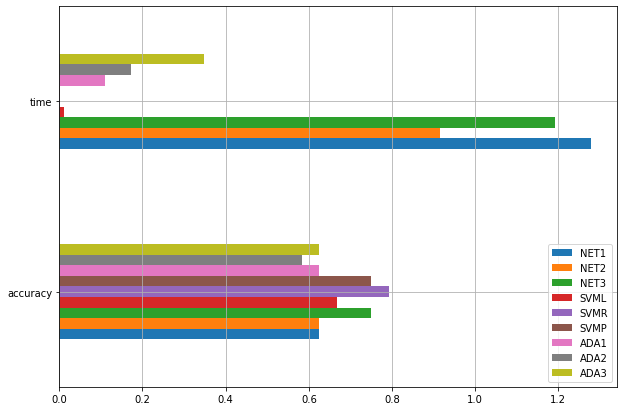

In [39]:
fig, ax = plt.subplots(figsize=(10,7))
metrics.plot(kind='barh', ax=ax)
ax.grid();

### Conclusion
When evaluated on a relatively small dataset, feedforward neural networks seem to be outperformed by support vector machines in both execution time and model accuracy. Adaboost on the other hand, seems to be a particularly ineffective algorithm for predicting credit default as it resulted in the highest execution times and no great leap in accuracy. Neural networks had historically had poorer accuracy than SVMs on a wide range of problems prior to the age of massive datasets, so it is worth investigating if a massively higher number of datapoints allows neural networks to surpass SVMs in credit default prediction. SVMs remain far less computationally expensive and are preferable under strict time constraints. 